In [1]:
import numpy as np
import imutils
import cv2
import pytesseract
from PIL import Image

from imutils.perspective import four_point_transform
from skimage.segmentation import clear_border
from typing import List

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [2]:
from imutils.perspective import four_point_transform
from skimage.segmentation import clear_border
import numpy as np
import imutils
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [27]:
import time

In [3]:
board = 'board7'
rotate = False

In [4]:
image=mpimg.imread(r"C:\Users\16477\Desktop\projects\sudoku-solver\examples\{}.jpg".format(board))

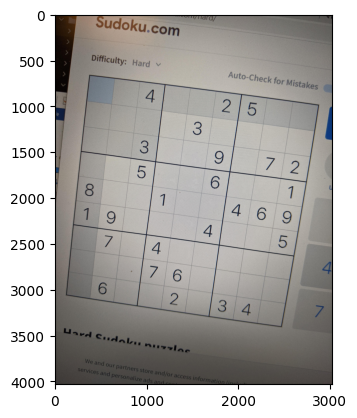

In [5]:
plt.imshow(image)

In [624]:
if rotate:
    image = np.rot90(image, -1)
    plt.imshow(image)
    im = Image.fromarray(image)
    im.save(r"C:\Users\16477\Desktop\projects\sudoku-solver\examples\{}.jpg".format(board))

In [6]:
image.shape

(817, 768, 3)

In [899]:
817*768

627456

In [7]:
arr=np.zeros((10,10))

In [9]:
x,y,_=image.shape

In [10]:
x,y

(817, 768)

In [6]:
resized = cv2.resize(image, dsize=(768, 817), interpolation = cv2.INTER_AREA)

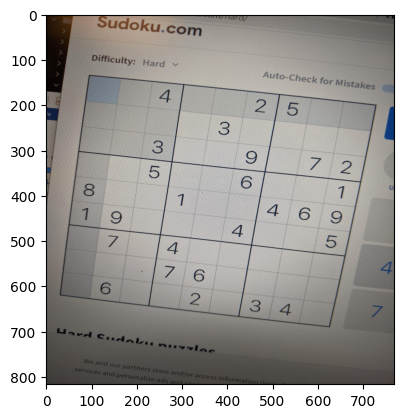

In [7]:
plt.imshow(resized)

In [8]:
def locate_board(*, image: np.ndarray, debug=False) -> np.ndarray:
    '''
    find bounding edges of sudoku board and apply linear
    transformation to bounded board to obtain rectangular form
    :param image:
    :return:
    '''

    # adaptive thresholding
    gray = cv2.cvtColor(
        src=image,
        code=cv2.COLOR_BGR2GRAY
    )
    #plt.imshow(gray)
    
    #if debug:
    #    plt.imshow(gray)
    
    blurred = cv2.GaussianBlur(
        src=gray,
        ksize=(7, 7),
        sigmaX=3
    )
    #plt.imshow(blurred)
    #if debug:
    #    plt.imshow(blurred)
    
    thresh = cv2.adaptiveThreshold(
        src=blurred,
        maxValue=255,
        adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        thresholdType=cv2.THRESH_BINARY,
        blockSize=11,
        C=2
    )
    #plt.imshow(thresh)
    thresh = cv2.bitwise_not(
        src=thresh
    )
    plt.imshow(thresh)
    # find contours and sort
    contours = cv2.findContours(
        image=thresh,
        mode=cv2.RETR_EXTERNAL,
        method=cv2.CHAIN_APPROX_SIMPLE
    )
    contours = imutils.grab_contours(cnts=contours)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    # loop over the contours
    puzzleCnt = None
    for contour in contours:
        perimeter = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * perimeter, True)
        if len(approx) == 4:
            puzzleCnt = approx
            break
    if puzzleCnt is None:
        raise Exception(("Could not find board."))
    board = four_point_transform(gray, puzzleCnt.reshape(4, 2))
    return board

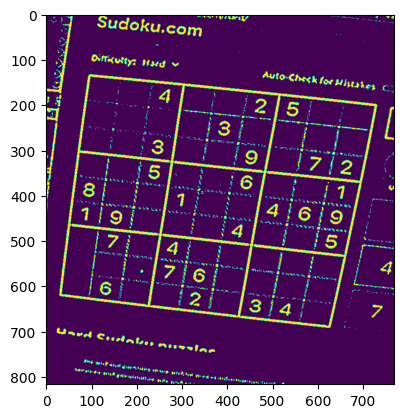

In [9]:
warped=locate_board(image=resized, debug=True)

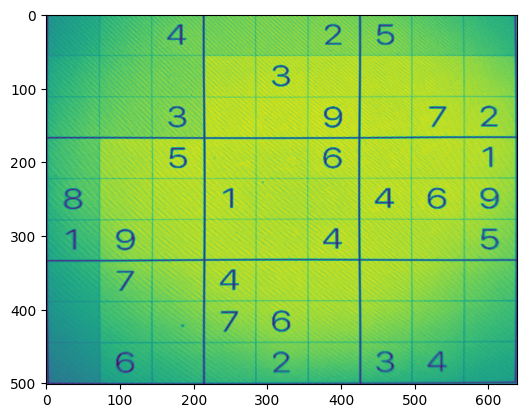

In [10]:
plt.imshow(warped)

In [168]:
overlay = cv2.putText(warped, '5', (25,100), cv2.FONT_HERSHEY_SIMPLEX, 
                   1.5, (255,0,0), 3, cv2.LINE_AA)

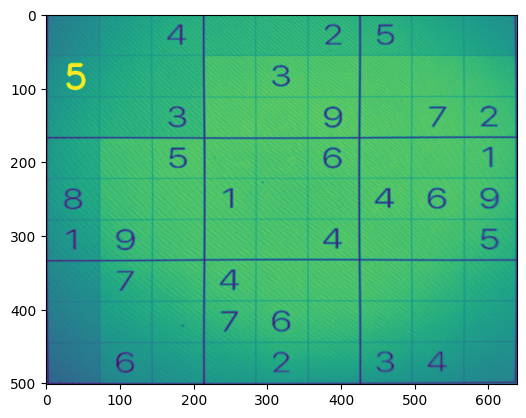

In [169]:
plt.imshow(overlay)

In [175]:
overlay = cv2.putText(img=warped, text='7', org=(155,100), fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
                   fontScale=1.5, color=(255,0,0), thickness=3, lineType=cv2.LINE_AA)

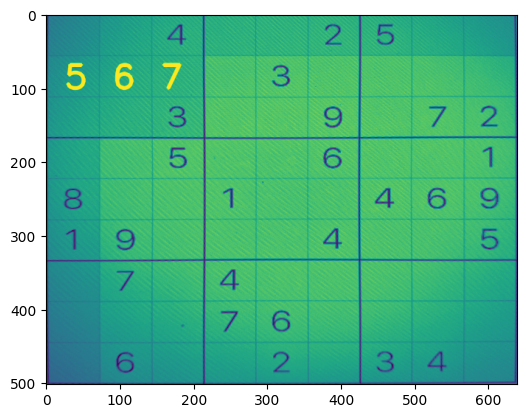

In [176]:
plt.imshow(overlay)

In [27]:
gray = cv2.cvtColor(
        src=resized,
        code=cv2.COLOR_BGR2GRAY
    )

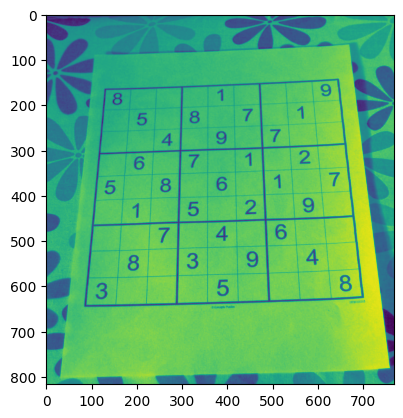

In [44]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))

In [48]:
from PIL import Image
import numpy as np
import io

In [49]:
plt.imshow(np.array(Image.open(io.BytesIO(image.tobytes()))))

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x0000012CB0336950>

In [52]:
_, im_png = cv2.imencode(".png", image)

In [53]:
io.BytesIO(im_png.tobytes())

In [758]:
def extract_digit(cell, debug=False):
    # apply automatic thresholding to the cell and then clear any
    # connected borders that touch the border of the cell
    
    #cell = cell[1:-1, ]
    
    thresh = cv2.threshold(cell, 0, 255,
        cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    thresh = clear_border(thresh)
    
    #if debug:
    #    plt.imshow(thresh)
    
    # find contours in the thresholded cell
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    
    #print(len(cnts))
    
    # if no contours were found than this is an empty cell
    if len(cnts) == 0:
        return None
    # otherwise, find the largest contour in the cell and create a
    # mask for the contour
    c = max(cnts, key=cv2.contourArea)
    mask = np.zeros(thresh.shape, dtype="uint8")
    
    cv2.drawContours(mask, [c], -1, 255, -1)
    
    # compute the percentage of masked pixels relative to the total
    # area of the image
    (h, w) = thresh.shape
    percentFilled = cv2.countNonZero(mask) / float(w * h)
    return len(cnts), percentFilled
    
    '''
    # if less than 3% of the mask is filled then we are looking at
    # noise and can safely ignore the contour
    if percentFilled < 0.03:    
        return None
    # apply the mask to the thresholded cell
    digit = cv2.bitwise_and(thresh, thresh, mask=mask)
    # check to see if we should visualize the masking step
    if debug:
        cv2.imshow("Digit", digit)
        cv2.waitKey(0)
    # return the digit to the calling function
    return digit
    '''

In [739]:
results = dict()

import os
from tqdm import tqdm
import matplotlib.pyplot as plt

boards = os.listdir(r"C:\Users\16477\Desktop\projects\sudoku-solver\examples")
for board in tqdm(boards):
    results[board] = {}
    image=mpimg.imread(r"C:\Users\16477\Desktop\projects\sudoku-solver\examples\{}".format(board))
    resized = cv2.resize(image, dsize=(768, 817), interpolation = cv2.INTER_AREA)
    warped=locate_board(image=resized, debug=True)
    m, n = warped.shape
    vstep, hstep = m // 9, n // 9
    for row in range(9):
        for col in range(9):
            cell = warped[row*vstep:(row + 1)*vstep, col*hstep:(col + 1)*hstep]
            digit = extract_digit(cell, debug=False)
            if digit is None:
                results[board][(row+1, col+1)] = None
            else:
                results[board][(row+1, col+1)] = {'countours': digit[0], 'percentFilled': digit[1]}

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 15.28it/s]


In [743]:
pct = []
for board, stats in results.items():
    for loc, res in stats.items():
        if res:
            pct.append(res['percentFilled'])
            if 0.025 <= res['percentFilled'] < 0.04:
                print(board, ': ', loc, res['percentFilled'])

board2.jpg :  (1, 1) 0.039886039886039885
board2.jpg :  (2, 8) 0.038461538461538464
board2.jpg :  (4, 9) 0.03886853886853887
board2.jpg :  (5, 5) 0.030118030118030117
board5.jpg :  (5, 1) 0.032551319648093845
board5.jpg :  (7, 4) 0.03167155425219941
board7.jpg :  (3, 8) 0.036619718309859155
board7.jpg :  (4, 9) 0.02765685019206146
board7.jpg :  (5, 4) 0.03380281690140845
board7.jpg :  (6, 1) 0.03636363636363636
board7.jpg :  (7, 2) 0.03687580025608195
board8.jpg :  (2, 4) 0.03535353535353535
board8.jpg :  (2, 9) 0.03591470258136925
board8.jpg :  (3, 7) 0.02861952861952862
board8.jpg :  (5, 2) 0.038159371492704826
board8.jpg :  (9, 1) 0.03170594837261504
board8.jpg :  (9, 7) 0.035072951739618406


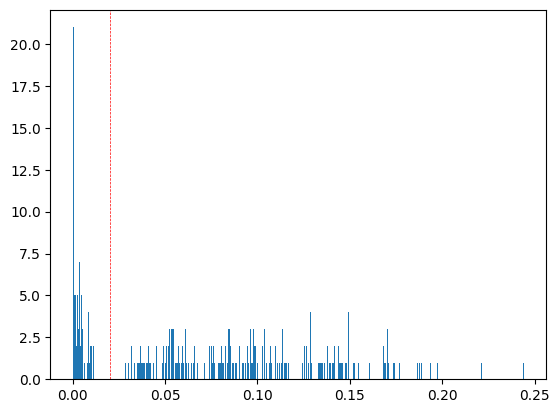

In [749]:
plt.hist(pct, bins=500)
plt.axvline(x=0.02, color='red', linestyle='--', linewidth=0.5)
plt.show()

In [893]:
CONFIG_FILE_PATH="SSSS"

In [894]:
try:
    y/s
except:
    raise OSError(f"Did not find config file at path: {CONFIG_FILE_PATH}")

OSError: Did not find config file at path: SSSS

In [11]:
def extract_digit(cell, debug=False):
    # apply automatic thresholding to the cell and then clear any
    # connected borders that touch the border of the cell
    
    #cell = cell[1:-1, ]
    
    thresh = cv2.threshold(src=cell, thresh=0, maxval=255,
        type=cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    
    thresh = clear_border(labels=thresh)
    
    #if debug:
    #    plt.imshow(thresh)
    
    # find contours in the thresholded cell
    cnts = cv2.findContours(image=thresh.copy(), mode=cv2.RETR_EXTERNAL,
        method=cv2.CHAIN_APPROX_SIMPLE)
    print(len(cnts))
    cnts = imutils.grab_contours(cnts=cnts)
    print(len(cnts))
    print(cnts)
    
    # if no contours were found than this is an empty cell
    if len(cnts) == 0:
        return None
    # otherwise, find the largest contour in the cell and create a
    # mask for the contour
    c = max(cnts, key=cv2.contourArea)
    print(type(c))
    mask = np.zeros(thresh.shape, dtype="uint8")
    
    cv2.drawContours(mask, [c], -1, 255, -1)
    
    # compute the percentage of masked pixels relative to the total
    # area of the image
    (h, w) = thresh.shape
    percentFilled = cv2.countNonZero(mask) / float(w * h)
    
    
    
    # if less than 3% of the mask is filled then we are looking at
    # noise and can safely ignore the contour
    if percentFilled < 0.03:    
        return None
    # apply the mask to the thresholded cell
    digit = cv2.bitwise_and(src1=thresh,
                            src2=thresh,
                            mask=mask)
    # check to see if we should visualize the masking step
    if debug:
        cv2.imshow("Digit", digit)
        cv2.waitKey(0)
    # return the digit to the calling function
    return digit
    

In [12]:
row, col =2,7
m, n = warped.shape
vstep, hstep = m // 9, n // 9

In [13]:
cell = warped[row*vstep:(row + 1)*vstep, col*hstep:(col + 1)*hstep]

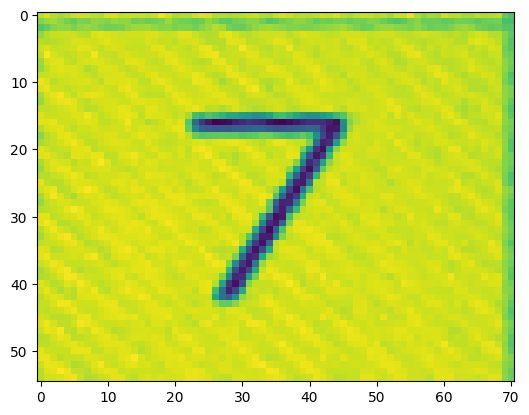

In [14]:
plt.imshow(cell)

In [16]:
digit = extract_digit(cell, debug=False)

2
1
(array([[[30, 15]],

       [[29, 16]],

       [[23, 16]],

       [[23, 17]],

       [[40, 17]],

       [[41, 18]],

       [[41, 19]],

       [[40, 20]],

       [[40, 21]],

       [[38, 23]],

       [[38, 24]],

       [[36, 26]],

       [[36, 27]],

       [[35, 28]],

       [[35, 29]],

       [[33, 31]],

       [[33, 32]],

       [[31, 34]],

       [[31, 35]],

       [[29, 37]],

       [[29, 38]],

       [[28, 39]],

       [[28, 40]],

       [[27, 41]],

       [[27, 42]],

       [[29, 42]],

       [[29, 41]],

       [[31, 39]],

       [[31, 38]],

       [[32, 37]],

       [[32, 36]],

       [[35, 33]],

       [[35, 32]],

       [[36, 31]],

       [[36, 30]],

       [[38, 28]],

       [[38, 27]],

       [[40, 25]],

       [[40, 24]],

       [[42, 22]],

       [[42, 21]],

       [[44, 19]],

       [[44, 18]],

       [[45, 17]],

       [[45, 16]],

       [[43, 16]],

       [[42, 15]],

       [[39, 15]],

       [[38, 16]],

       [[35, 16

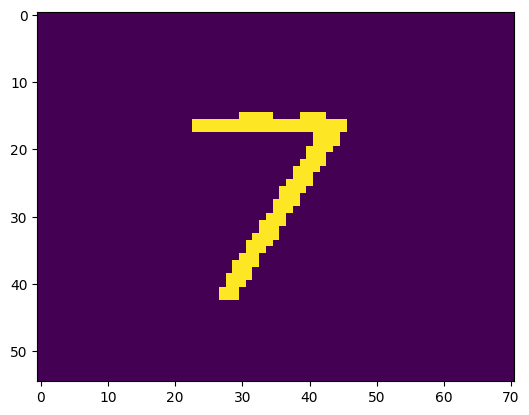

In [17]:
plt.imshow(digit)

In [886]:
cv2.bitwise_and(src1=digit)

error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'bitwise_and'
> Overload resolution failed:
>  - bitwise_and() missing required argument 'src2' (pos 2)
>  - bitwise_and() missing required argument 'src2' (pos 2)


In [18]:
def crop_digit(*, digit: np.ndarray) -> np.ndarray:
    '''

    :param digit:
    :return:
    '''

    m, n = digit.shape
    left, right = 0, n - 1
    top, bottom = 0, m - 1

    while left < n:
        if np.sum(digit[:, left]) > 255:
            break
        left += 1
    while right > 0:
        if np.sum(digit[:, right]) > 255:
            break
        right -= 1
    while top < m:
        if np.sum(digit[top, :]) > 255:
            break
        top += 1
    while bottom > 0:
        if np.sum(digit[bottom, :]) > 255:
            break
        bottom -= 1
    
    cropped_digit = np.zeros((bottom - top + 2 * 20, right - left + 2 * 5), dtype="uint8")
    cropped_digit[20: (20 + bottom - top), 5: 5 + (right - left)] = digit[top: bottom, left: right]
    return cropped_digit

In [19]:
cropped_digit = crop_digit(digit=digit)

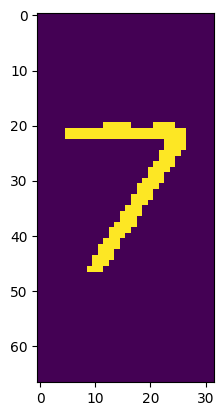

In [20]:
plt.imshow(cropped_digit)

In [21]:
digits = np.hstack(tuple(cropped_digit for _ in range(5)))

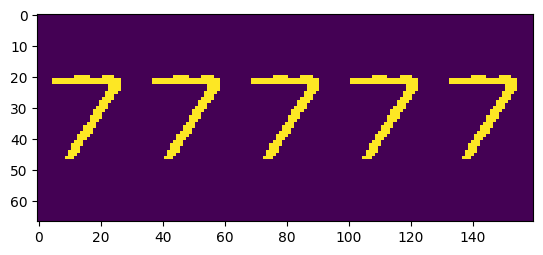

In [22]:
plt.imshow(digits)

In [28]:
start = time.time()
text = pytesseract.image_to_string(digits)
print('pytesseract', np.round(time.time() - start, 2))
del start

pytesseract 0.16


In [29]:
text

'77777\n'

In [25]:
def get_num(*, chars: str) -> int:
    freqs = [0] * 9
    nums = int(''.join([x for x in chars if x.isdigit()]))
    while nums:
        num = nums % 10
        freqs[num - 1] += 1
        nums //= 10
    return freqs.index(max(freqs)) + 1

In [26]:
get_num(chars=text)

7

In [50]:
digits.shape

(67, 160)

In [56]:
resized_digits = cv2.resize(digits, dsize=(40, 16), interpolation = cv2.INTER_AREA)

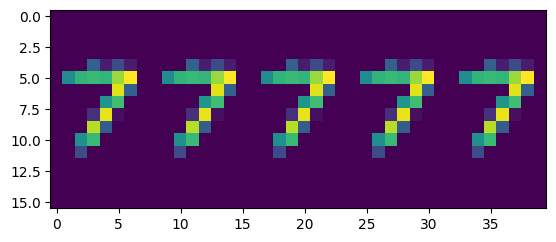

In [57]:
plt.imshow(resized_digits)

In [58]:
start = time.time()
text = pytesseract.image_to_string(resized_digits)
print('pytesseract', np.round(time.time() - start, 2))
del start

pytesseract 0.14


In [59]:
text

''

In [60]:
get_num(chars=text)

ValueError: invalid literal for int() with base 10: ''